![image.png](attachment:image.png)

## TEAM CHALLENGE: PIPELINES

Este notebook describe el team challenge que deberéis presentar en clase de dentro de dos sprints. Es decir, tenéis el sprint de la semana que viene para trabajar en este challenge, y en el sprint siguiente lo presentáis. Está pensado para que trabajéis con pipelines y es muy abierto, pero se valorarán los siguientes puntos:

* Usar pipelines
* Usar estimadores supervisados y no supervisados
* Usar onehotencoder de forma que no haya errores si una variable categórica tiene valores que aparecen o no aparecen en train, validación y test
* Usar GridsearchCV
* Usar validación cruzada y explicar la gran ventaja de los pipelines en validación cruzada (pensad en qué puede ser ; ) )
* Calculad alguna regresión donde el target no esté ditribuido de forma gaussiana
* Calculad alguna clasificación donde el target esté desbalanceado (¡¡¡ojo!!!)

Consejo:

Estos dos enlaces os pueden ayudar mucho:

https://scikit-learn.org/stable/common_pitfalls.html

https://imbalanced-learn.org/stable/common_pitfalls.html

Y, si os fijáis, el segundo enlace es de Imbalanced Learn (No Scikit-learn)

**Plazo de entrega**

Deberéis subir vuestras soluciones a GitHub y compartirlas con los profesores antes de las presentaciones.
En la presentación podéis apoyaros brevemente en vuestro código pero debe haber entre 3 y 7 diapositivas donde expliquéis vuestros casos de uso de ML con pipelines.

Deberéis presentar vuestros trabajos durante el Sprint 20 durante 15-20 min máximo.

¡Ánimo, que domináis el ML! 

![pipeline_extra.png](attachment:pipeline_extra.png)

#### Pipeline Bebidas energéticas

##### Librerias

In [61]:
# # Importación de bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



# Configuración de estilo para gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


#### Carga y exploración de los datos

In [4]:
# Cargar el archivo CSV y dividir en columnas
data = pd.read_csv('./data/empowering_drinks.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 1 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Azúcares|Vitamínas del grupo B|Cafeína|Ácido Cítrico|Taurina  153 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


In [6]:
# Dividir la columna en características
data_split = data['Azúcares|Vitamínas del grupo B|Cafeína|Ácido Cítrico|Taurina'].str.split('|', expand=True)


In [7]:
data_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       153 non-null    object
 1   1       153 non-null    object
 2   2       153 non-null    object
 3   3       153 non-null    object
 4   4       153 non-null    object
dtypes: object(5)
memory usage: 6.1+ KB


In [8]:
# Renombrar las columnas
data_split.columns = ['Azúcares', 'Vitaminas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']


In [9]:
data_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Azúcares               153 non-null    object
 1   Vitaminas del grupo B  153 non-null    object
 2   Cafeína                153 non-null    object
 3   Ácido Cítrico          153 non-null    object
 4   Taurina                153 non-null    object
dtypes: object(5)
memory usage: 6.1+ KB


In [10]:
# Convertir las columnas a tipo numérico
data_split = data_split.apply(pd.to_numeric, errors='coerce')
data_split.info()
#comprobar que todos estan en numérico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitaminas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


#### MiniEDA

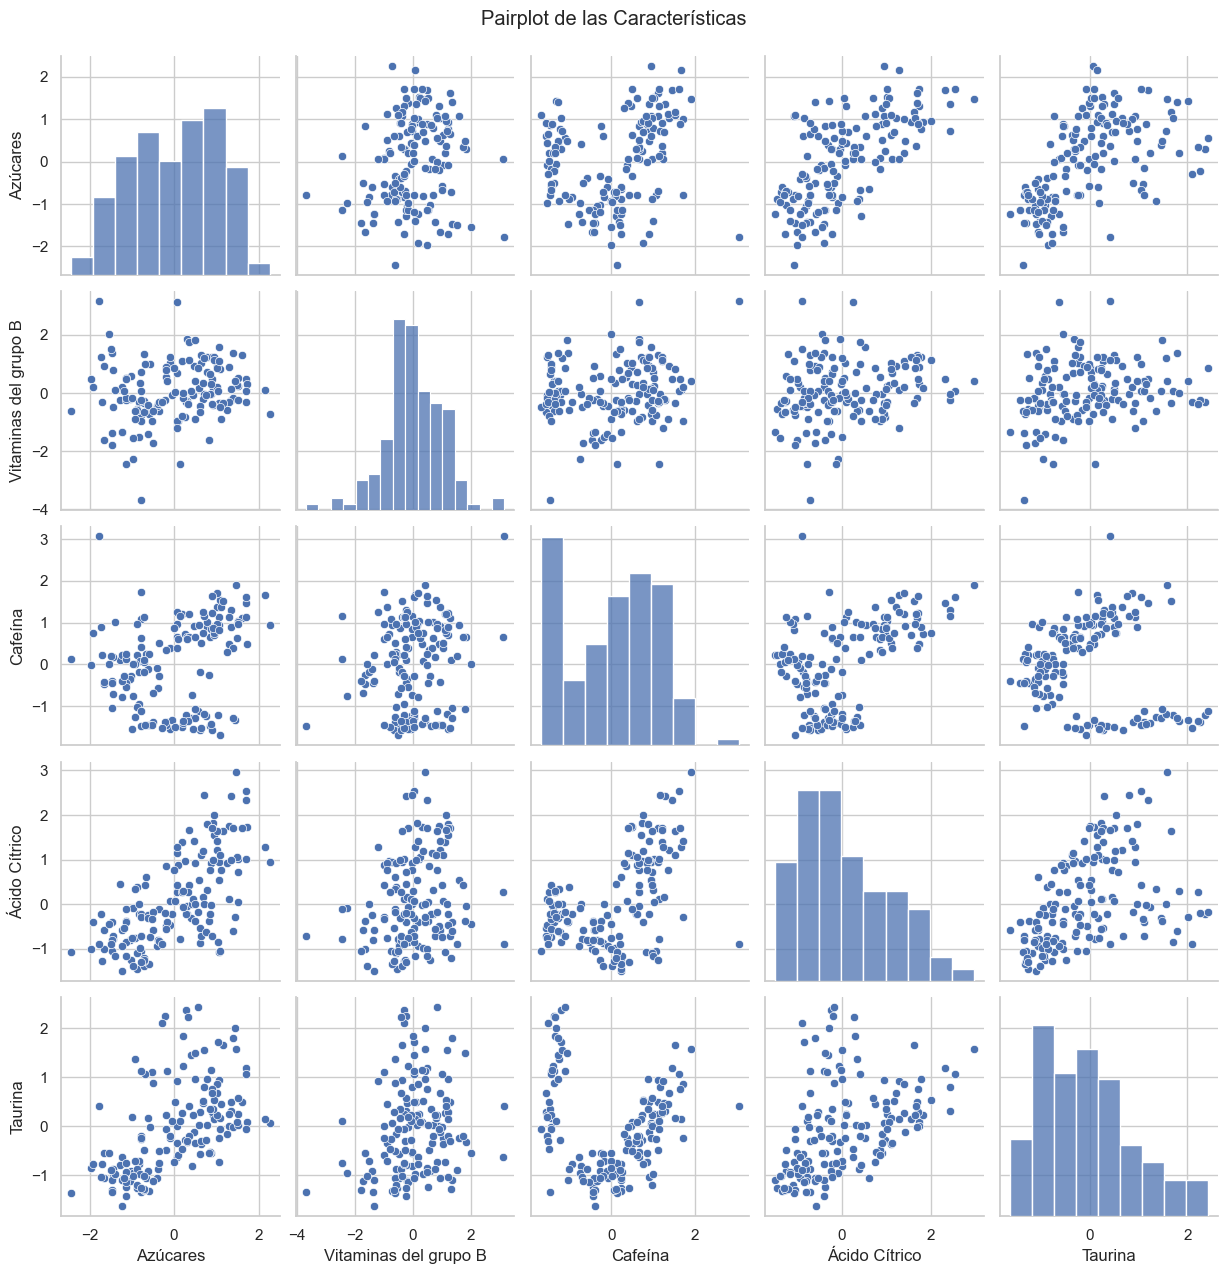

In [11]:
# Visualización con pairplot
sns.pairplot(data_split)
plt.suptitle('Pairplot de las Características', y = 1.02) # elevamos el título para evitar que se superpoga a los gráficos
plt.show()

In [12]:
# Con esta esta visualización podemos observar como se distribuyen y relacioanan las características antes del procesado y modelado.
# Podemos identificar algunas características desbalanceadas como la Cafeína, Ácido Cítrico y la Taurina. 

In [13]:
data_split.head()

,Azúcares,Vitaminas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [14]:
data_split.describe()

,Azúcares,Vitaminas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


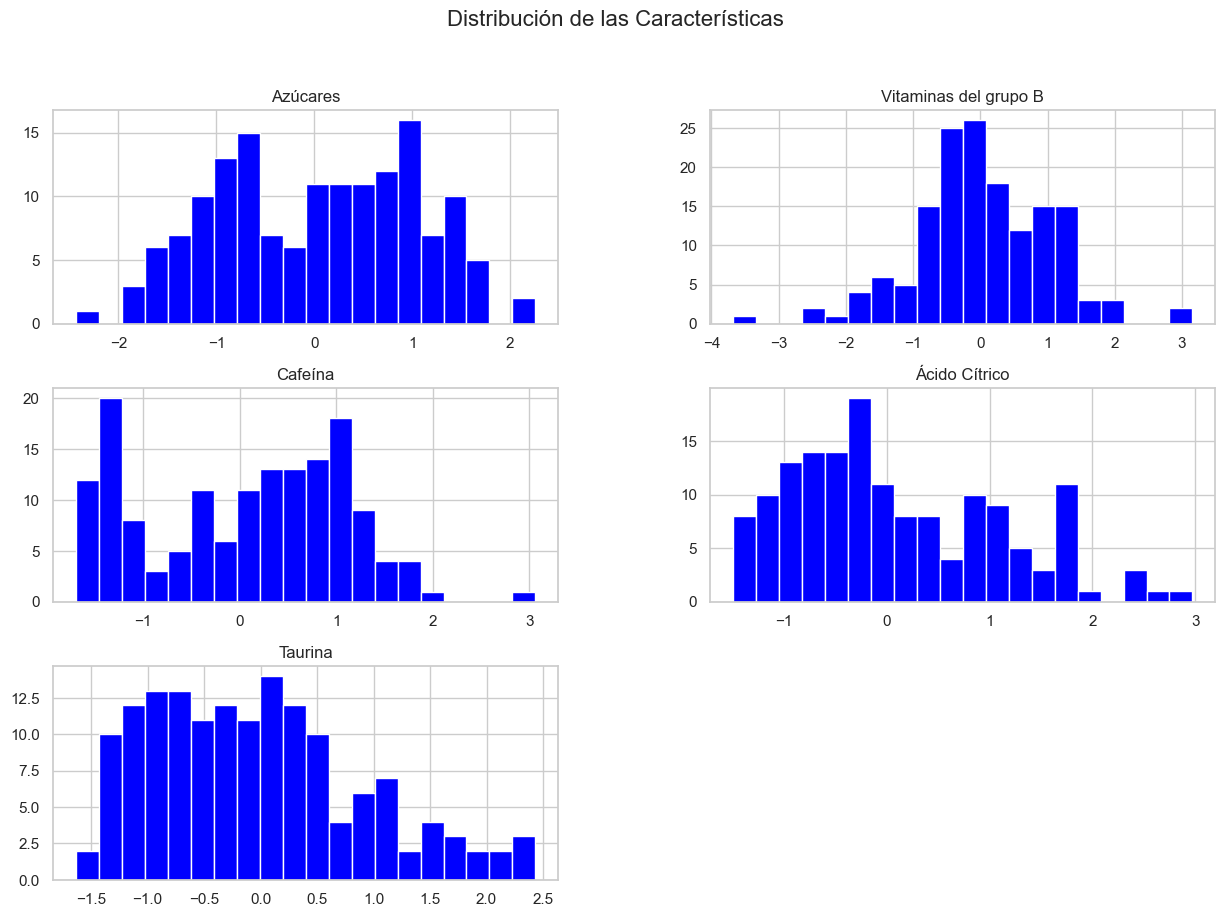

In [15]:
# Histograma
data_split.hist(bins=20, figsize=(15, 10), color='blue')
plt.suptitle('Distribución de las Características', fontsize=16)
plt.show()

In [16]:
'''
La taurina tienen asimetría. En cambio la cafeína y el ácido cítrico muestran distribuciones más uniformes.
'''

'\nLa taurina tienen asimetría. En cambio la cafeína y el ácido cítrico muestran distribuciones más uniformes.\n'

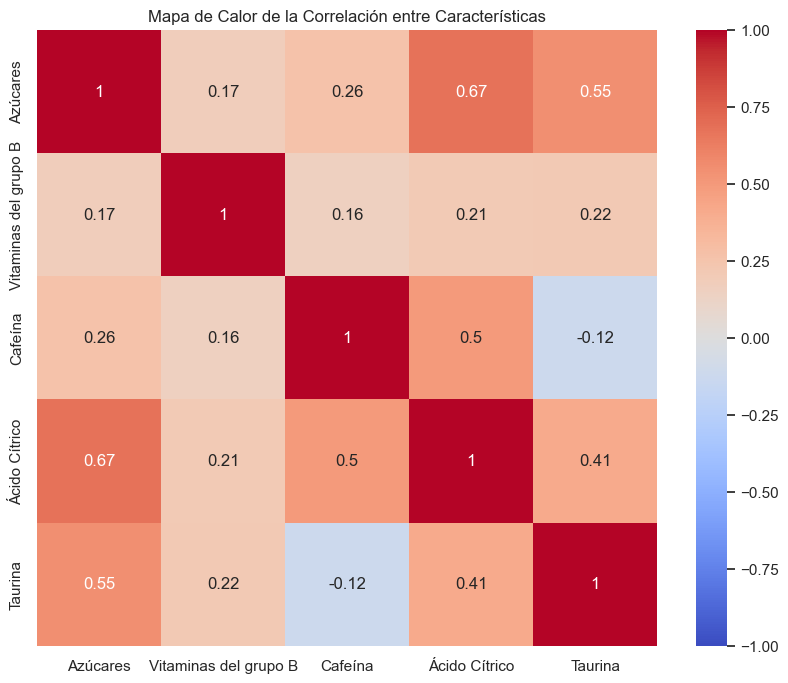

In [17]:
# Mapa de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(data_split.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de la Correlación entre Características')
plt.show()

In [18]:
'''
Las correlaciones entre las características son débiles, lo que sugiere que cada una aporta información distinta. 
Esto es útil para métodos de clustering y poder segmentar los datos según la cercanía.
'''

'\nLas correlaciones entre las características son débiles, lo que sugiere que cada una aporta información distinta. \nEsto es útil para métodos de clustering y poder segmentar los datos según la cercanía.\n'

In [19]:
# Varibable para comprobar los valores nulos
missing_values = data_split.isnull().sum()

In [20]:
# Imputar valores nulos con la media, aunque en esta ocasión no es necesario.
data_split.fillna(data_split.mean(), inplace=True)

In [21]:
missing_values
# sin valores nulos en el dataset, aunque ya lo comprobramos en el .info

Azúcares                 0
Vitaminas del grupo B    0
Cafeína                  0
Ácido Cítrico            0
Taurina                  0
dtype: int64

#### Configuración del pipeline

In [22]:
# Configurar el pipeline de preprocesamiento
procesado_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandarizar las características
    ('pca', PCA(n_components=2))   # Reducir a 2 dimensiones para visualización
])

Explicación de porque usamos StandardScaler y PCA

Se trato en anteriores unidades, parece que los datos ya han sido trabajados.
Sin embargo, vamos a escalar los datos. Con ello hacemos que la media tenga 0 y una desviación estandar de 1.  
Si tuvieramos características con diferentes escalas influirían en la distancia. 

PCA: reducimos la dimensionalidad y facilitamos la visaluación. Los hacemos a 2 para poder ver como se distribuyen mejor los datos.


In [23]:
# Aplicar el pipeline a los datos
data_procesado = procesado_pipeline.fit_transform(data_split)

In [24]:
# Crear un DataFrame de los datos procesados
procesado_df = pd.DataFrame(data_procesado, columns=['PCA1', 'PCA2'])
procesado_df.head()

,PCA1,PCA2
0,1.848711,0.487488
1,0.493153,0.803962
2,1.640039,0.850821
3,3.325544,0.398238
4,0.637990,0.557511


Comparación de modelos No Supervisados

El objetivo es identificar cual es el modelo de clustering más adecuado para segmentar los datos.

El objetivo es ajustar los modelos de clustering, aplicar una búsqueda de hiperparámetros y evaluar la calidad de los clusters formados mediante la puntuación de silueta. 

Usaremos 3 modelos para comparar: KMeans, DBSCAN, Clustering Jerarquico

La puntuación de silueta: nos dice que similares son los puntos de un cluster en comparación a los de otros. La puntuación va de -1 a 1.

    Cerca de 1: Los puntos están bien agrupados y claramente separados de otros clusters.
    Cerca de 0: Los puntos están en los límites de los clusters.
    Valores negativos: Los puntos pueden estar mal asignados a un cluster.


In [25]:
# KMeans: GridSearchCV realiza la búsqueda de hiperparámetros automáticamente y devuelve la mejor configuración basada en la puntuación de silueta.

In [26]:
# Definir una función de evaluación de silueta
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    # Verificar que haya más de un cluster antes de calcular la puntuación de silueta
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Puntuación inválida si solo hay un cluster

In [27]:
# Configuración de los parámetros a probar
kmeans_param_grid = [2, 3, 4, 5]

In [28]:
# Variables para almacenar los mejores resultados
best_kmeans_score = -1
best_kmeans_params = None

In [29]:
'''
Este código daba error
# Configuración de GridSearchCV para KMeans
kmeans = KMeans(random_state=42)
kmeans_param_grid = {'n_clusters': [2, 3, 4, 5]}
grid_search_kmeans = GridSearchCV(
    estimator=kmeans,
    param_grid=kmeans_param_grid,
    scoring=make_scorer(silhouette_scorer),
    cv=3  # Validación cruzada de 3 partes
)
'''

"\nEste código daba error\n# Configuración de GridSearchCV para KMeans\nkmeans = KMeans(random_state=42)\nkmeans_param_grid = {'n_clusters': [2, 3, 4, 5]}\ngrid_search_kmeans = GridSearchCV(\n    estimator=kmeans,\n    param_grid=kmeans_param_grid,\n    scoring=make_scorer(silhouette_scorer),\n    cv=3  # Validación cruzada de 3 partes\n)\n"

In [70]:
# Probar diferentes configuraciones para KMeans
print(f"Evaluación de diferentes configuraciones de KMeans:")
for n_clusters in kmeans_param_grid:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(procesado_df)
    # Verificar que haya más de un cluster antes de calcular la puntuación de silueta
    if len(set(labels)) > 1:
        score = silhouette_score(procesado_df, labels)
        print(f'KMeans con n_clusters={n_clusters}: Puntuación de silueta={score:.3f}')# Vamos a dejar que como mucho salgan 3 decimales por eso usamos en adelante .3f
        if score > best_kmeans_score:
            best_kmeans_score = score
            best_kmeans_params = {'n_clusters': n_clusters}

Evaluación de diferentes configuraciones de KMeans:
KMeans con n_clusters=2: Puntuación de silueta=0.462
KMeans con n_clusters=3: Puntuación de silueta=0.616
KMeans con n_clusters=4: Puntuación de silueta=0.545
KMeans con n_clusters=5: Puntuación de silueta=0.527


In [71]:
# Imprimir la mejor configuración y puntuación obtenida para KMeans
print(f"Mejor configuración de KMeans:")
print(f"Parámetros: {best_kmeans_params}, Puntuación de silueta: {best_kmeans_score:.3f}")

Mejor configuración de KMeans:
Parámetros: {'n_clusters': 3}, Puntuación de silueta: 0.616


In [32]:
# DBSCAN: Es una búsqueda manual más sencilla mediante un bucle para probar combinaciones de parámetros y calcular la puntuación de silueta para cada configuración.

In [33]:
# Configuración de parámetros a probar para DBSCAN
dbscan_param_grid = [{'eps': eps, 'min_samples': min_samples} for eps in [0.3, 0.5, 0.7] for min_samples in [3, 5, 10]]

In [34]:
best_dbscan_score = -1
best_dbscan_params = None

In [ ]:
# Probar diferentes configuraciones de DBSCAN
print(f"Evaluación de diferentes configuraciones de DBSCAN:")
for params in dbscan_param_grid:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(procesado_df)
    if len(set(labels)) > 1:  # Verificar que haya más de un cluster
        score = silhouette_score(procesado_df, labels)
        print(f"DBSCAN con eps={params['eps']}, min_samples={params['min_samples']}: Puntuación de silueta={score:.3f}")
        if score > best_dbscan_score:
            best_dbscan_score = score
            best_dbscan_params = params


Evaluación de diferentes configuraciones de DBSCAN:
DBSCAN con eps=0.3, min_samples=3: Puntuación de silueta=0.270
DBSCAN con eps=0.3, min_samples=5: Puntuación de silueta=0.212
DBSCAN con eps=0.3, min_samples=10: Puntuación de silueta=0.074
DBSCAN con eps=0.5, min_samples=3: Puntuación de silueta=-0.015
DBSCAN con eps=0.5, min_samples=5: Puntuación de silueta=0.324
DBSCAN con eps=0.5, min_samples=10: Puntuación de silueta=0.482
DBSCAN con eps=0.7, min_samples=3: Puntuación de silueta=0.159
DBSCAN con eps=0.7, min_samples=5: Puntuación de silueta=0.264
DBSCAN con eps=0.7, min_samples=10: Puntuación de silueta=0.323


In [36]:
# Imprimir la mejor configuración y puntuación obtenida para DBSCAN
print("\nMejor configuración de DBSCAN:")
print(f"Parámetros: {best_dbscan_params}, Puntuación de silueta: {best_dbscan_score:.3f}")


Mejor configuración de DBSCAN:
Parámetros: {'eps': 0.5, 'min_samples': 10}, Puntuación de silueta: 0.482


In [37]:
# Clustering Jerárquico: se evalua de forma iterativa para diferentes valores de n_clusters.

In [ ]:
# Probar Agglomerative Clustering con diferentes configuraciones de n_clusters
best_agg_score = -1
best_agg_params = None
print(f"Evaluación de diferentes configuraciones de Agglomerative Clustering:")



Evaluación de diferentes configuraciones de Agglomerative Clustering:


In [39]:
for n_clusters in [2, 3, 4, 5]:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(procesado_df)
    if len(set(labels)) > 1:  # Verificar que haya más de un cluster
        score = silhouette_score(procesado_df, labels)
        print(f"Agglomerative Clustering con n_clusters={n_clusters}: Puntuación de silueta={score:.3f}")
        if score > best_agg_score:
            best_agg_score = score
            best_agg_params = {'n_clusters': n_clusters}

Agglomerative Clustering con n_clusters=2: Puntuación de silueta=0.482
Agglomerative Clustering con n_clusters=3: Puntuación de silueta=0.613
Agglomerative Clustering con n_clusters=4: Puntuación de silueta=0.547
Agglomerative Clustering con n_clusters=5: Puntuación de silueta=0.525


In [73]:
# Imprimir la mejor configuración y puntuación obtenida para Agglomerative Clustering
print(f"Parámetros: {best_agg_params}, Puntuación de silueta: {best_agg_score:.3f}")

Parámetros: {'n_clusters': 3}, Puntuación de silueta: 0.613


#### Gráficas y visualización de los 3 modelos

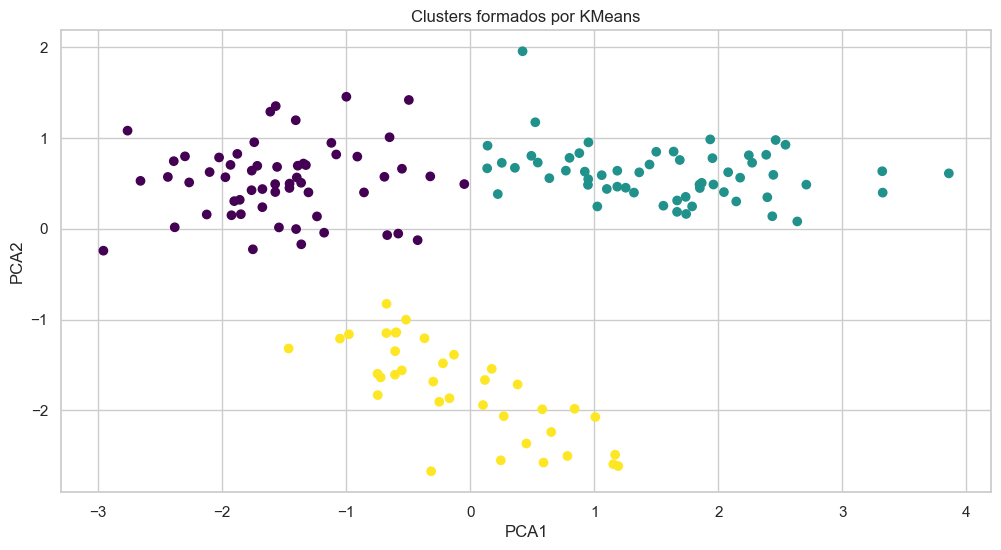

In [41]:
# Visualización de KMeans
plt.scatter(procesado_df['PCA1'], procesado_df['PCA2'], c=KMeans(n_clusters=best_kmeans_params['n_clusters'], random_state=42).fit_predict(procesado_df), cmap='viridis')
plt.title('Clusters formados por KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

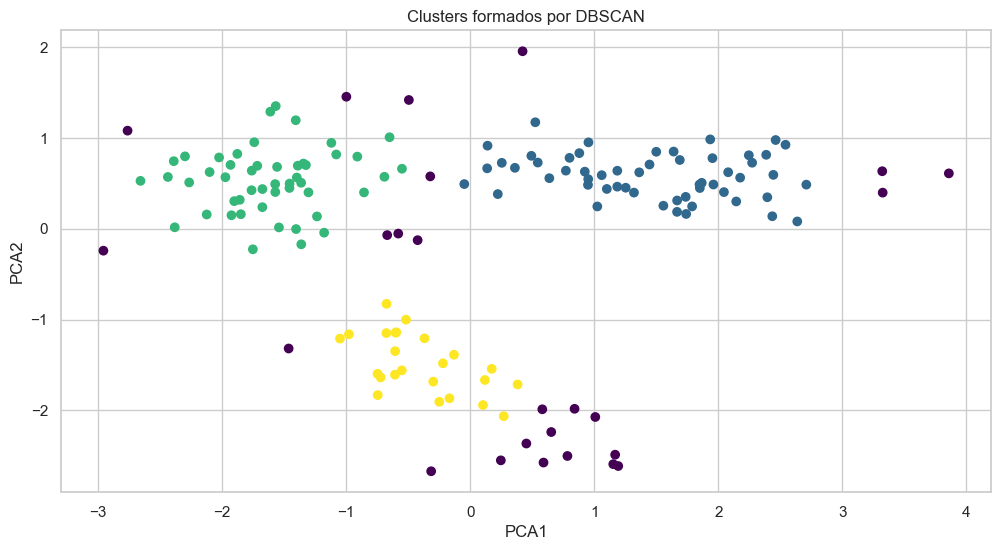

In [42]:
# Visualización de DBSCAN
plt.scatter(procesado_df['PCA1'], procesado_df['PCA2'], c=DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples']).fit_predict(procesado_df), cmap='viridis')
plt.title('Clusters formados por DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

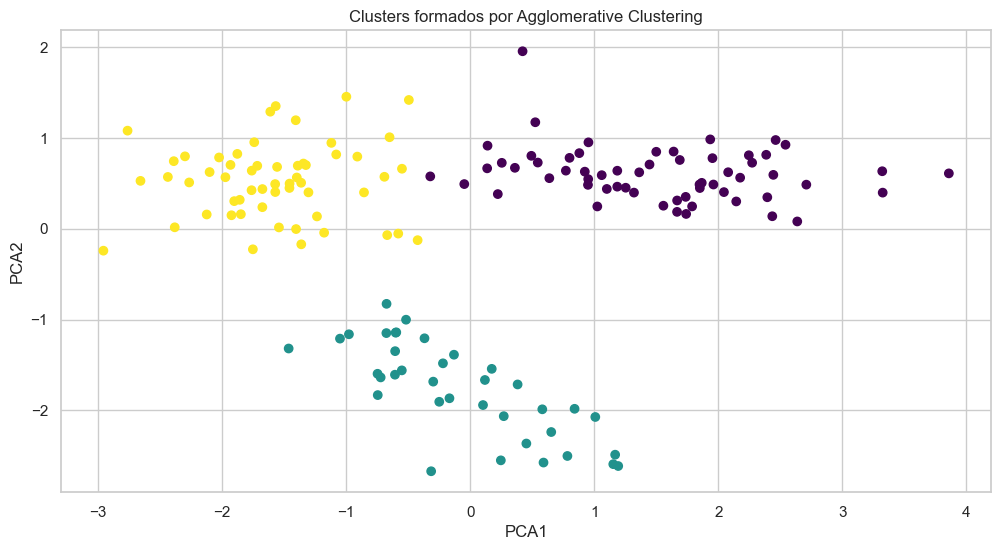

In [43]:
# Visualización de Agglomerative Clustering
plt.scatter(procesado_df['PCA1'], procesado_df['PCA2'], c=AgglomerativeClustering(n_clusters=best_agg_params['n_clusters']).fit_predict(procesado_df), cmap='viridis')
plt.title('Clusters formados por Agglomerative Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

#### Análisis de Resultados y Elección del Mejor Modelo
Con base en los resultados de las puntuaciones de silueta obtenidas:

KMeans:  
>Mejor puntuación de silueta: 0.616 con n_clusters=3  

DBSCAN:  
>Mejor puntuación de silueta: 0.482 con eps=0.5 y min_samples=10  

Agglomerative Clustering:  
>Mejor puntuación de silueta: 0.613 con n_clusters=3  

#### Elección del Mejor Modelo
El mejor modelo según la puntuación de silueta es KMeans con n_clusters=3, que obtuvo una puntuación de 0.616.   
Esto sugiere que KMeans forma clusters bien definidos en comparación con DBSCAN y Agglomerative Clustering.

Visualmente podemos observar que en el KMeans estan menos dispersos los puntos.

#### Análisis en profundidad de los clusters

In [45]:
# Ajustar KMeans con la mejor configuración y asignar los clusters a los datos
kmeans = KMeans(n_clusters=3, random_state=42)
data_split['Cluster'] = kmeans.fit_predict(procesado_df)


In [46]:
# Mostrar las primeras filas del DataFrame con la asignación de clusters
data_split.head()

,Azúcares,Vitaminas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.518613,0.232053,1.034819,1.013009,0.251717,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1


In [74]:
# Análisis descriptivo por cluster
cluster_summary = data_split.groupby('Cluster').mean()
print(f"Resumen de las características por cluster:")
print(cluster_summary)

Resumen de las características por cluster:
         Azúcares  Vitaminas del grupo B   Cafeína  Ácido Cítrico   Taurina
Cluster                                                                    
0       -0.947445              -0.441034 -0.018308      -0.699755 -0.912493
1        0.874784               0.417971  1.008681       1.103987  0.201002
2        0.193422               0.190284 -1.382700      -0.302761  0.933003


In [ ]:
# Mostrar el tamaño de cada cluster
cluster_sizes = data_split['Cluster'].value_counts()
print(f"Tamaño de cada cluster:")
print(cluster_sizes)


Tamaño de cada cluster:
Cluster
1    58
0    58
2    37
Name: count, dtype: int64


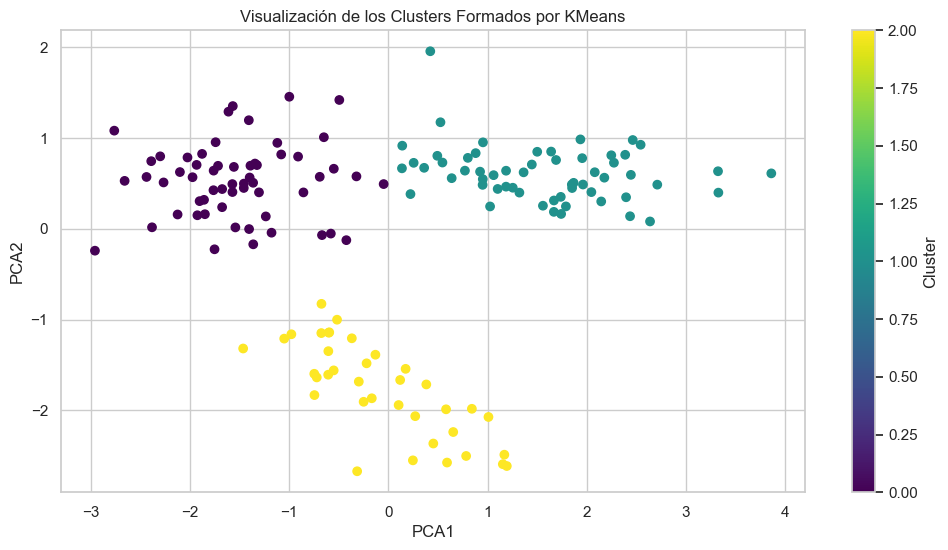

In [49]:
plt.figure(figsize=(12, 6))
plt.scatter(procesado_df['PCA1'], procesado_df['PCA2'], c=data_split['Cluster'], cmap='viridis')
plt.title('Visualización de los Clusters Formados por KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()


#### División del Dataset en Conjuntos de Entrenamiento y Prueba

In [51]:
# División de los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test = train_test_split(procesado_df, test_size=0.2, random_state=42)

In [52]:
X_train.shape

(122, 2)

In [54]:
X_test.shape

(31, 2)

#### Evaluación de KMeans en Train-Test Split

In [ ]:
# Ajustar KMeans al conjunto de entrenamiento
kmeans = KMeans(n_clusters = best_kmeans_params['n_clusters'], random_state = 42)
kmeans.fit(X_train)

KMeans(n_clusters=3, random_state=42)

In [56]:
# Predecir clusters en el conjunto de entrenamiento y prueba
labels_train = kmeans.predict(X_train)
labels_test = kmeans.predict(X_test)

In [57]:
# Calcular la puntuación de silueta en ambos conjuntos
silhouette_train = silhouette_score(X_train, labels_train)
silhouette_test = silhouette_score(X_test, labels_test)

In [ ]:
print(f"Puntuación de Silueta en el conjunto de entrenamiento: {silhouette_train:.3f}")
print(f"Puntuación de Silueta en el conjunto de prueba: {silhouette_test:.3f}")
# La puntuación de silueta en el conjunto de prueba es similar a la del conjunto de entrenamiento, indica que el modelo es estable y generaliza bien.

Puntuación de Silueta en el conjunto de entrenamiento: 0.604
Puntuación de Silueta en el conjunto de prueba: 0.658


#### Validación Cruzada

In [ ]:
#Definir una función de validación cruzada personalizada para KMeans
def cross_val_kmeans(data, n_clusters, cv=5):
    scores = []
    subconjunto = len(data) // cv  # Dividir los datos en partes iguales
    
    for i in range(cv):
        # Dividir los datos en subconjuntos de entrenamiento y prueba
        test_data = data[i * subconjunto:(i+1) *subconjunto]
        train_data = pd.concat([data[:i*subconjunto], data[(i+1)*subconjunto:]], axis = 0)
        
        #Ajustar KMeans al conjunto de entrenamiento
        kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
        kmeans.fit(train_data)
        
        # Predecir clusters en el conjunto de prueba
        labels_test = kmeans.predict(test_data)
        
        # Calcular la puntuación de silueta para el conjunto de prueba
        if len(set(labels_test)) > 1:  # Asegurarse de que hay más de un cluster
            score = silhouette_score(test_data, labels_test)
            scores.append(score)
    
    return scores

In [ ]:
#Realizar la validación cruzada personalizada para KMeans
n_clusters = best_kmeans_params['n_clusters']
scores = cross_val_kmeans(procesado_df, n_clusters)

In [69]:
#Imprimir las puntuaciones de cada iteración y el promedio
scores
print(f"Promedio de Puntuación de Silueta en Validación Cruzada: {np.mean(scores):.3f}")

Promedio de Puntuación de Silueta en Validación Cruzada: 0.518
